# Jacobo Casado de Gracia - Visión por computador
# En este notebook se va a realizar la práctica 1 de Visión por Computador.
# Antes de comenzar, se adjuntan los métodos de la práctica 0 puesto a que, en ciertas partes del código se usan para facilitar el almacenamiento y representación de las imágenes.

In [1]:
# Jacobo Casado de Gracia. Práctica 0 de Visión por Computador.
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import uuid
from scipy.stats import norm

def pintaImagen(imagen):
  figura = plt.figure(uuid.uuid4(), figsize = (15,15))
  plt.imshow(imagen, cmap='gray')

def leeImagen(filename, flagColor):
  img = cv.imread(filename, flagColor)
  pintaImagen(img)
  return img

def pintaI(im):
  minimo = np.min(im)
  maximo = np.max(im)
  longitud = maximo - minimo
  # Pasamos al intervalo [0,1] la imagen.
  im = (im - minimo) / longitud
  im = im * 255
  pintaImagen(im)


# EJERCICIO 1. Implementación de la máscara discreta 1D de la función Gaussiana, la derivada primera y segunda de la Gaussiana.

* ## La función implementada para crear cada una de estas tres máscaras (se crearán tres funciones cuyo valor de retorno es la máscara en cuestión) recibe como parámetros, o bien la longitud de la máscara, o bien el sigma (varianza) del valor de la gaussiana discretizada.

* ## Primero, se va a crear un método que recibe una longitud de vector y devuelve un vector de números enteros de esa misma longitud, cuyo centro es el número 0 y comienza desde los números negativos hasta los positivos.
## Es decir, si llamamos a generaVector(5), la salida devolverá un vector: [-2,-1,0,1,2]
## Esto se hace con fines de ahorrarnos creaciones de vectores de este tipo de manera reiterada, y, en general, ahorrarnos tiempo y espacio.

In [2]:
# Jacobo Casado de Gracia. Práctica 1 Visión por Computador. Año 2021
# Ejercicio 1. Implementación de la máscara gaussiana de 1D.
# Esta máscara recibe el valor de sigma o bien la longitud de la máscara.
# Dependiendo del parámetro que reciba, si bien es sigma se calculará la longitud de la máscara y si se da la máscara se procederá a calcular sigma.
import cv2 as cv
import math
import matplotlib.pyplot as plt

def generaVector(longitud):
    valor_min = ((longitud - 1) / 2) * (-1)
    valor_max = abs(valor_min)

    vector = np.zeros(longitud)
    # Llenamos el vector con los valores de x que se van a introducir en las funciones que nos discretizarán la gaussiana, la primera derivada 
    # y la segunda derivada para obtener la máscara final.
    vector[0] = valor_min
    for i in range (1, longitud):
        vector[i] = vector[i-1] + 1
    return vector


# A continuación, definiremos las funciones de la gaussiana, y su primera y segunda derivada.

## Éstas son funciones matemáticas que reciben un valor de x, así como un valor de la desviación típica de dicha distribución, sigma, que en cuyo caso y dependiendo de éste último, representa la "escala" del kernel, y devuelven el valor de y la distribución correspondiente (gaussiana, primera derivada o segunda).

## Lo primero que vamos a hacer es incidir en el aspecto de que la máscara 2D de la Gaussiana (y sus derivadas) es separable en dos máscaras 1D, las cuales son, además, iguales.

## La propiedad de la igualdad no ocurre para todas las máscaras, pero sí se cumple para las máscaras de discretización de la gaussiana.

## Es decir, sabemos que podemos transformar todo kernel 2D en dos kernel 1D pero no todos los kernel 2D se descomponen en kernel 1D iguales (visto en la página 36 de las diapositivas de teoría); en este caso sí se puede ya que la función de la gaussiana 2D se puede separar como el PRODUCTO de las funciones en x e y de esta misma.

## La fórmula de la distribución usada para la gaussiana se ha visto en las diapositivas de teoría, en el apartado "Gaussian Kernel as a Filter" de esta asignatura (página 35 de las diapositivas de teoría), y las derivadas se han conseguido en un proceso derivativo simple.

## Recordar que, al ser igual la máscara 1D en ambas dimensiones, x e y, sus derivadas también serán iguales, ya que en una derivaremos en x, y en la otra derivaremos en y, obteniendo, de nuevo, la misma máscara.

## Por tanto, y antes de comenzar con los cálculos de la máscara discreta, se procede a adjuntar estas tres funciones matemáticas descritas anteriormente, que nos serán herramientas útiles.

In [3]:
def gaussiana(sigma, valor):
    return  math.exp(-0.5 * ((valor**2)/(sigma*sigma)))

def primera_derivada(sigma, valor):
    return (-1) * (valor / (sigma**2)) * math.exp((-1) * ((valor**2) / (2 * sigma**2)))

def segunda_derivada(sigma, valor):
    return (-1) * ( ((sigma**2) - (valor**2)) / ( (sigma**4) * math.exp((valor**2) / (2*(sigma**2))) ) )

# Discretización de la gaussiana 1D (y sus derivadas)
# En realidad, la diferencia entre discretizar la Gaussiana y sus derivadas será la función que aplicaremos a nuestro vector muestreado para obtener un valor diferente del Kernel dependiendo de si queremos la Gaussiana o alguna de sus derivadas.
## Sabiendo ya de antemano que el kernel de la Gaussianna es separable, calcularemos un kernel 1D DISCRETO.
## Ojo, discreto.
## Eso significa que, o bien necesitamos saber la longitud de la máscara donde vamos a discretizar la Gaussiana, o bien el sigma (o varianza) de esta gaussiana.
## Debemos de tener en cuenta que:
1. ### El kernel final que obtengamos debe de sumar 1 si sumamos todos sus elementos (la Gaussiana como distribución de probabilidad, cubre un 100% desde -infinito a +infinito, o bien el área de la Gaussiana procedente de integrar sobre x e y da 1).

## Por tanto, muestrearemos la señal en un vector de valores de X, y hacemos que sumen 1.

2. ### Sabemos que la longitud en píxeles de la máscara es, aproximadamente, y haciendo cuentas:

## $longitud = 2 * parteentera[2.5 * sigma] + 1$

## (Sabemos que casi todos los valores de la distribución se encuentran dentro de tres desviaciones estándar de la media)

# Podemos apreciar que la longitud en píxeles de la máscara siempre será IMPAR.

3. ## De -2.5 * desviación típica a 2.5 * desviación típica aproximadamente hay un 98% de área (en la distribución Gaussiana)

4. ## La longitud en píxeles de la máscara siempre va a dar impar, al calcularse mediante la fórmula de arriba (2 * (parte entera de 2.5 * sigma) + 1)

## Por tanto, el método que haremos para discretizar la Gaussiana sera uno que, o bien reciba un Gamma prefijado, o bien reciba una longitud de máscara (a la cual, y por la razón de la ecuación que hemos visto justo antes, le corresponde un sigma asociado a esta longitud).

## Eso será lo primero que haremos en el método.

# SIGUIENTE PASO: MUESTREO DEL VECTOR.

## Lo siguiente que vamos a hacer es generar un vector de la misma longitud de la máscara a crear y evaluaremos los puntos en X que correspondan tal que, si n es el tamaño de la máscara, el vector tendrá esta construcción:

## $[-(n-1)/2, ... , 0 , ... , (n-1)/2]$

## De tal manera que, si la longitud de la máscara es, por ejemplo, 5, el vector que obtendríamos sería:
## $[-2, -1, 0, 1, 2]$

## Queremos este vector (generado con la función generaVector especificada al principio de la práctica 1) porque evaluaremos los puntos de este vector con la función gaussiana que hemos también especificado anteriormente, para obtener el valor de la gaussiana en estos puntos.

## Una vez obtenido el valor de la gaussiana en estos puntos, nos aseguramos de que la sumatoria de todos los valores de este vector sumen 1, es decir, NORMALIZAMOS el vector para que cumpla las propiedades que cumple la distribución gaussiana.

# El vector resultante de todas estas operaciones sería la gaussiana discretizada y muestreada en un intervalo dado de longitud N (o sigma) dado y especificado previamente por el usuario, EN FORMA DE VECTOR 1D.



In [4]:
def mascaraGaussiana1D(sigma, longitud):
    # Si nos pasan sigma, calculamos la longitud de la máscara.
    # Sabemos que la longitud en píxeles de la máscara, es aproximadamente y haciendo cuentas, 2 * parte entera de [2,5 + sigma] + 1 = longitud.

    if longitud is None:
        longitud = 2 * int(2.5 * sigma) + 1

    # Por el mismo razonamiento, dada la longitud de la máscara, podemos extraer el sigma correspondiente.
    if sigma is None:
        sigma = (longitud - 1) / 5

    # Teniendo la longitud del vector, vamos a hallar el rango de valores de x que se van a evaluar en la función gaussiana, primera y segunda derivada.
    # Pensando un poco, si el vector es de longitud 5, nuestro vector es [-2,-1,0,1,2]; si es de longitud 7 sería [-3,-2,-1, 0, 1, 2, 3]. 
    # Por tanto, el valor mínimo y máximo del vector es fácil de calcular:
        
    valor_min = ((longitud - 1) / 2) * (-1)
    valor_max = abs(valor_min)

    mascara_gaussiana = np.arange(int(-2.5 * sigma), int(2.5 * sigma) + 1,dtype=np.float64)

    # Aplicamos el producto para obtener el vector normalizado a [0,1].
    for i in range (0, longitud):
        mascara_gaussiana[i] = gaussiana(sigma, mascara_gaussiana[i])
    
    mascara_gaussiana = mascara_gaussiana/sum(mascara_gaussiana)
    #print('Gaussiana: ', mascara_gaussiana)
    return(mascara_gaussiana)


## Realizamos exactamente lo mismo para crear la primera y segunda derivada, con una sutil diferencia:
## En vez de evaluar nuestro vector muestreado con la función de la Gaussiana, simplemente lo evaluamos usando la derivada primera y segunda de ésta.
## También debemos de normalizar el vector para que conforme aumente el tamaño de máscara, se produzca el mismo efecto de derivada, multiplicando por sigma cada uno de los valores de la máscara (de este tamaño, al multiplicar por este constante, los valores no se ven afectados por el aumento de sigma)

In [5]:
def mascaraGaussiana1D_derivada(sigma, longitud):
    # Si nos pasan sigma, calculamos la longitud de la máscara.
    # Sabemos que la longitud en píxeles de la máscara, es aproximadamente y haciendo cuentas, 2 * parte entera de [2,5 + sigma] + 1 = longitud.

    if longitud is None:
        longitud = 2 * int(2.5 * sigma) + 1

    # Por el mismo razonamiento, dada la longitud de la máscara, podemos extraer el sigma correspondiente.
    if sigma is None:
        sigma = ((longitud - 1) / 5)

    # Teniendo la longitud del vector, vamos a hallar el rango de valores de x que se van a evaluar en la función gaussiana, primera y segunda derivada.
    # Pensando un poco, si el vector es de longitud 5, nuestro vector es [-2,-1,0,1,2]; si es de longitud 7 sería [-3,-2,-1, 0, 1, 2, 3]. 
    # Por tanto, el valor mínimo y máximo del vector es fácil de calcular:
        
    valor_min = ((longitud - 1) / 2) * (-1)
    valor_max = abs(valor_min)

    mascara_gaussiana = np.arange(int(-2.5 * sigma), int(2.5 * sigma) + 1,dtype=np.float64)
    
    # Aplicamos el producto para obtener el vector normalizado a [0,1].
    for i in range (0, longitud):
        mascara_gaussiana[i] = primera_derivada(sigma, mascara_gaussiana[i])
        mascara_gaussiana[i] = mascara_gaussiana[i] * sigma
    # print('Primera derivada: ', mascara_gaussiana)
   # mascara_gaussiana = mascara_gaussiana/sum(mascara_gaussiana)
    return(mascara_gaussiana)


### Hacemos lo mismo con la segunda derivada y su fórmula correspondiente, multiplicando por sigma para normalizar su efecto con cualquier tamaño de kernel.

In [6]:
def mascaraGaussiana1D_derivada_segunda(sigma, longitud):
    # Si nos pasan sigma, calculamos la longitud de la máscara.
    # Sabemos que la longitud en píxeles de la máscara, es aproximadamente y haciendo cuentas, 2 * parte entera de [2,5 + sigma] + 1 = longitud.

    if longitud is None:
        longitud = 2 * int(2.5 * sigma) + 1

    # Por el mismo razonamiento, dada la longitud de la máscara, podemos extraer el sigma correspondiente.
    if sigma is None:
        sigma = ((longitud - 1) / 5)

    # Teniendo la longitud del vector, vamos a hallar el rango de valores de x que se van a evaluar en la función gaussiana, primera y segunda derivada.
    # Pensando un poco, si el vector es de longitud 5, nuestro vector es [-2,-1,0,1,2]; si es de longitud 7 sería [-3,-2,-1, 0, 1, 2, 3]. 
    # Por tanto, el valor mínimo y máximo del vector es fácil de calcular:
        
    valor_min = ((longitud - 1) / 2) * (-1)
    valor_max = abs(valor_min)

    mascara_gaussiana = np.arange(int(-2.5 * sigma), int(2.5 * sigma) + 1,dtype=np.float64)

    # Aplicamos el producto para obtener el vector normalizado a [0,1].
    for i in range (0, longitud):
        mascara_gaussiana[i] = segunda_derivada(sigma, mascara_gaussiana[i])
        mascara_gaussiana[i] = mascara_gaussiana[i] * sigma
    
        # mascara_gaussiana = mascara_gaussiana/sum(mascara_gaussiana)
    # print('Segunda derivada: ', mascara_gaussiana)
    return(mascara_gaussiana)

# Representación, comparación e inferencia
## A continuación, representaremos en ejes cartesianos las máscaras obtenidas en forma de función 1D y comparemos con la función nativa de OpenCV que genera estos Kernels, llamada $OpenCV.getDerivKernels()$.
## Haremos esta comparación con los Kernels de tamaño 5, 7 y 9 respectivamente.

# Representación de los Kernels de tamaño 5, 7 y 9 de la GAUSSIANA
## Representaremos en dos gráficos de manera separada ambos kernel y, posteriormente, compararemos los resultados.
## getDerivKernels(0,1,5)[0] nos devuelve un kernel Gaussiano de tamaño 5.
## getDerivKernels(0,1,5)[1] nos devuelve un kernel de primera derivada de la Gaussiana de tamaño 5.

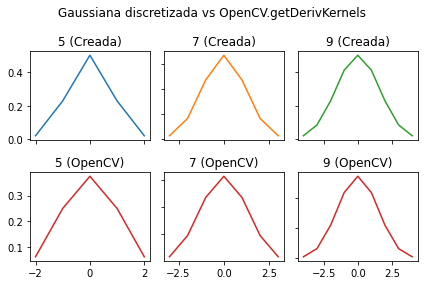

In [7]:
# Representamos nuestras máscaras gaussianas de longitud 5, 7 y 9, junto a las que crea OpenCV con getDerivKernels gráficamente, para después poder inferir en los datos.
mascara1D_size5 = mascaraGaussiana1D(None,5)
mascara1D_size7 = mascaraGaussiana1D(None,7)
mascara1D_size9 = mascaraGaussiana1D(None,9)
openCV1D_size5 = cv.getDerivKernels(0,1,5,normalize=1)
openCV1D_size7 = cv.getDerivKernels(0,1,7,normalize=1)
openCV1D_size9 = cv.getDerivKernels(0,1,9,normalize=1)


x_5 = generaVector(5)
x_7 = generaVector(7)
x_9 = generaVector(9)

fig, axs = plt.subplots(2, 3)

fig.suptitle('Gaussiana discretizada vs OpenCV.getDerivKernels')

axs[0, 0].plot(x_5, mascara1D_size5, 'tab:blue')
axs[0, 0].set_title('5 (Creada)')
axs[0, 1].plot(x_7, mascara1D_size7, 'tab:orange')
axs[0, 1].set_title('7 (Creada)')
axs[0, 2].plot(x_9, mascara1D_size9, 'tab:green')
axs[0, 2].set_title('9 (Creada)')
axs[1, 0].plot(x_5, openCV1D_size5[0], 'tab:red')
axs[1, 0].set_title('5 (OpenCV)')
axs[1, 1].plot(x_7, openCV1D_size7[0], 'tab:red')
axs[1, 1].set_title('7 (OpenCV)')
axs[1, 2].plot(x_9, openCV1D_size9[0], 'tab:red')
axs[1, 2].set_title('9 (OpenCV)')

for ax in axs.flat:
    ax.label_outer()

fig.tight_layout()
plt.show()


## Como podemos comprobar, la máscara obtenida discretizando la gaussiana y la que crea openCV, para tamaños de máscara de 7 y 9, es prácticamente la misma; en tamaño 5 no se da tanto el parecido ya que la gaussiana que OpenCV crea cuando se llama a la función getDerivKernels es una gaussiana creada aproximada con la binomial, por tanto, es muy difícil que el sigma obtenido por esta aproximación, en un tamaño de máscara tan bajo, sea el mismo que discretizando la gaussiana. Conforme aumentamos el tamaño de máscara, ambas representaciones convergen en parecido.


# Representación de los kernels de la primera derivada de la Gaussiana
## (Los creados en este apartado y los de OpenCV)
## Para representar la primera derivada, tenemos que especificar con un 1 el primer parámetro en la función CV.getDerivKernels(); de esta manera, estamos derivando en X. 
## Posteriormente, obtendremos la máscara 1D en X (ya derivada) referenciándonos con [0] al objeto que devuelve esta función.

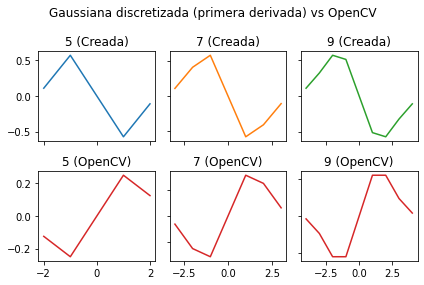

In [8]:
# Representamos nuestras máscaras gaussianas de longitud 5, 7 y 9, junto a las que crea OpenCV con getDerivKernels gráficamente, para después poder inferir en los datos.
mascara1D_size5 = mascaraGaussiana1D_derivada(None,5)
mascara1D_size7 = mascaraGaussiana1D_derivada(None,7)
mascara1D_size9 = mascaraGaussiana1D_derivada(None,9)
openCV1D_size5 = cv.getDerivKernels(1,1,5,normalize=1)
openCV1D_size7 = cv.getDerivKernels(1,1,7,normalize=1)
openCV1D_size9 = cv.getDerivKernels(1,1,9,normalize=1)

x_5 = generaVector(5)
x_7 = generaVector(7)
x_9 = generaVector(9)

fig, axs = plt.subplots(2, 3)

fig.suptitle('Gaussiana discretizada (primera derivada) vs OpenCV')

axs[0, 0].plot(x_5, mascara1D_size5, 'tab:blue')
axs[0, 0].set_title('5 (Creada)')
axs[0, 1].plot(x_7, mascara1D_size7, 'tab:orange')
axs[0, 1].set_title('7 (Creada)')
axs[0, 2].plot(x_9, mascara1D_size9, 'tab:green')
axs[0, 2].set_title('9 (Creada)')
axs[1, 0].plot(x_5, openCV1D_size5[0], 'tab:red')
axs[1, 0].set_title('5 (OpenCV)')
axs[1, 1].plot(x_7, openCV1D_size7[0], 'tab:red')
axs[1, 1].set_title('7 (OpenCV)')
axs[1, 2].plot(x_9, openCV1D_size9[0], 'tab:red')
axs[1, 2].set_title('9 (OpenCV)')

for ax in axs.flat:
    ax.label_outer()

fig.tight_layout()
plt.show()


## En este caso podemos apreciar que las máscaras de primera derivada que openCV crea son la máscara simétrica resultante a la que hemos creado nosotros discretizando la gaussiana.
## Esto ocurre debido a que los Kernel que openCV devuelve con esta función están ya invertidos con la intención de que se van a usar para convolucionar; ya sabemos que al convolucionar, se necesita dar la vuelta a la máscara. Por tanto, openCV devuelve el Kernel ya dado la vuelta para la convolución.

# Hacemos lo mismo con la segunda derivada.
## Simplemente hemos de introducir un 2 en el primer parámetro de la función getDerivKernels; de esta manera, cuando hagamos getDerivKernels[0] accederemos a la máscara 1D en X, que será la segunda derivada.

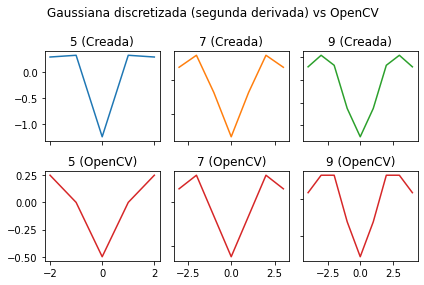

In [9]:
# Representamos nuestras máscaras gaussianas de longitud 5, 7 y 9, junto a las que crea OpenCV con getDerivKernels gráficamente, para después poder inferir en los datos.
mascara1D_size5 = mascaraGaussiana1D_derivada_segunda(None,5)
mascara1D_size7 = mascaraGaussiana1D_derivada_segunda(None,7)
mascara1D_size9 = mascaraGaussiana1D_derivada_segunda(None,9)
openCV1D_size5 = cv.getDerivKernels(2,1,5,normalize=1)
openCV1D_size7 = cv.getDerivKernels(2,1,7,normalize=1)
openCV1D_size9 = cv.getDerivKernels(2,1,9,normalize=1)

x_5 = generaVector(5)
x_7 = generaVector(7)
x_9 = generaVector(9)

fig, axs = plt.subplots(2, 3)

fig.suptitle('Gaussiana discretizada (segunda derivada) vs OpenCV')

axs[0, 0].plot(x_5, mascara1D_size5, 'tab:blue')
axs[0, 0].set_title('5 (Creada)')
axs[0, 1].plot(x_7, mascara1D_size7, 'tab:orange')
axs[0, 1].set_title('7 (Creada)')
axs[0, 2].plot(x_9, mascara1D_size9, 'tab:green')
axs[0, 2].set_title('9 (Creada)')
axs[1, 0].plot(x_5, openCV1D_size5[0], 'tab:red')
axs[1, 0].set_title('5 (OpenCV)')
axs[1, 1].plot(x_7, openCV1D_size7[0], 'tab:red')
axs[1, 1].set_title('7 (OpenCV)')
axs[1, 2].plot(x_9, openCV1D_size9[0], 'tab:red')
axs[1, 2].set_title('9 (OpenCV)')

for ax in axs.flat:
    ax.label_outer()

fig.tight_layout()
plt.show()


## Como podemos ver, son bastante parecidos los resultados y podemos asumir que la máscara de la gaussiana está relativamente bien hecha; cabe destacar que cuanto más aumentamos el tamaño de máscara, mayor parecido tienen los gráficos.
## Probaremos el uso de las máscaras creadas en este apartado más tarde con una imagen.

# EJERCICIO 2
## Calcular las máscaras discretas 1D de longitud 5 y 7 de alisamiento y de derivada de primer orden usando la aproximación binomial de la Gaussiana.
## Como hemos visto en teoría, para aproximar la binomial a la gaussiana debemos de tomar el vector correspondiente a la longitud de máscara que queramos (será un piso en concreto de la pirámide de Pascal) y normalizarlo, es decir, hacer que la suma de todos sus valores valgan 1, para convertirlo en una aproximación fiel al kernel Gaussiano, sin serlo como tal.
## A nosotros nos vale con saber que la primera "planta" de la pirámide, o el primer kernel binomial (de longitud 3) es el siguiente: $[1,2,1]$
## Para obtener los siguientes kernels de tamaño 5,7,9... lo único que tendremos que hacer es convolucionar este kernel consigo mismo para obtener el de 5, si quisiéramos obtener el de 7 convolucionaríamos el kernel de 5 obtenido anteriormente de nuevo con este kernel... Es decir, son convoluciones iterativas del mismo kernel, el $[1,2,1].
## Por tanto, cuando definamos la longitud del kernel gaussiano, únicamente tendremos que convolucionar el kernel base $[1,2,1]$ un número de veces determinado y normalizarlo. 
## De esa manera, obtendríamos el kernel gaussiano a partir de la distribución binomial vectorizada.
# A continuación se adjunta el código correspondiente a la creación de la pirámide de pascal de longitud determinada, y posteriormente a su normalización (para obtener el kernel gaussiano)

In [10]:
def piramidePascal(longitud):

    base = np.array([1,2,1], dtype = object)
    long3 = [1,2,1]

    if (longitud > 3):
        convoluciones = int((longitud - 3)/2)+1
        for i in range (1, convoluciones):
            base = np.convolve(base, long3)
            
    return base

def mascaraAlisamientoAproximada(longitud):
    mascara = np.array(piramidePascal(longitud))
    return (mascara / sum(mascara))

# Para la derivada, sin embargo, haremos un proceso un poco más largo.
## Seguiremos utilizando la pirámide de Pascal, pero en este caso, si queremos una máscara de longitud $M$ utilizaremos la máscara de longitud 3 de la derivada de la Gaussiana (que sabemos que es, por definición y visto en las clases de teoría, $[-1,0,1]$, y convolucionaremos una máscara de longitud $M - 2$ con esta máscara derivada para obtener la máscara de longitud $M$). La longitud des $M-2$ porque vamos a convolucionar un kernel con otro que siempre va a ser de semilado 1.
# Ligera anotación: en este ejercicio, como todavía no se ha pedido implementar la convolución de dos vectores, se ha usado Numpy.Convolve para realizarla.


In [11]:
# A continuación, haremos la máscara de derivada de primer orden usando la función del apartado A que calcula la primera derivada y la entrada es nuestra gaussiana (pero en este caso, aproximada)
# con la binomial)
def primeraDerivadaAproximada(longitud):
    mascara = np.array(piramidePascal(longitud - 2))
    mascara = mascara / sum(mascara)

    mascara_derivada_long3 = [-1,0,1]

    # Ya se ha aplicado la máscara de alisamiento, ya que hemos aproximado a la gaussiana.
    # Lo que nos queda es convolucionar con el vector -1, 0, 1 para obtener la derivada.
    derivada = np.convolve(mascara, mascara_derivada_long3)
    return(derivada)

# Definidas ambas funciones, veremos los Kernel que obtenemos de llamar a estas funciones con tamaño de máscara de 5 y 7, para ver los kernels que hemos obtenido.
# Como hemos de comparar estos kernels con los obtenidos de la función cv.getDerivKernels(0,1,9), que sabemos que devuelve kernels de tamaño 9 (el tercer parámetro de la función openCV es el tamaño de máscara), a la hora de hacer la comparación, crearemos kernels de tamaño 9 con las funciones anteriormente creadas y comentadas.

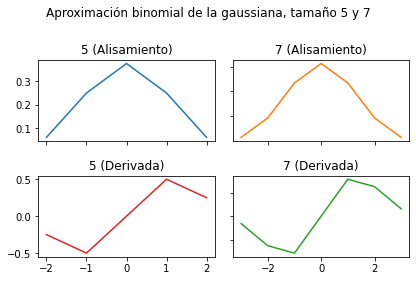

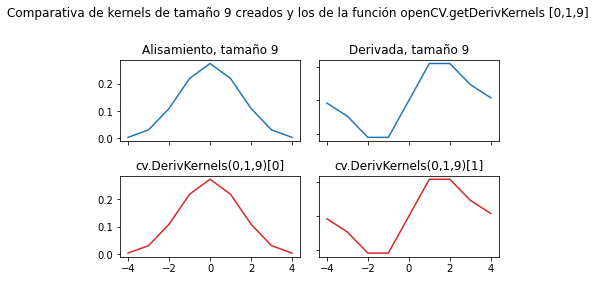

In [12]:
def ejercicio2():

    x_5 = generaVector(5)
    x_7 = generaVector(7)

    mascara1D_size5 = mascaraAlisamientoAproximada(5)
    mascara1D_size7 = mascaraAlisamientoAproximada(7)

    mascara1D_size5_derivada = primeraDerivadaAproximada(5)
    mascara1D_size7_derivada = primeraDerivadaAproximada(7)


    fig, axs = plt.subplots(2,2)
    fig.suptitle('Aproximación binomial de la gaussiana, tamaño 5 y 7')

    axs[0, 0].plot(x_5, mascara1D_size5, 'tab:blue')
    axs[0, 0].set_title('5 (Alisamiento)')
    axs[0, 1].plot(x_7, mascara1D_size7, 'tab:orange')
    axs[0, 1].set_title('7 (Alisamiento)')
    axs[1, 0].plot(x_5, mascara1D_size5_derivada, 'tab:red')
    axs[1, 0].set_title('5 (Derivada)')
    axs[1, 1].plot(x_7, mascara1D_size7_derivada, 'tab:green')
    axs[1, 1].set_title('7 (Derivada)')

    for ax in axs.flat:
        ax.label_outer()

    fig.tight_layout(pad = 1.5)

    plt.show()

    # Segunda parte: comparativa de los kernels de tamaño 9 con los de OpenCV.

    x_9 = generaVector(9)

    mascara1D_size9 = mascaraAlisamientoAproximada(9)
    mascara1D_size9_derivada = primeraDerivadaAproximada(9)

    gaussiana_tamaño9 = cv.getDerivKernels(0,1,9, normalize= 1)[0]
    primeraderivada_tamaño9 = cv.getDerivKernels(0,1,9, normalize=1)[1]

    fig, axs = plt.subplots(2,2)
    fig.suptitle('Comparativa de kernels de tamaño 9 creados y los de la función openCV.getDerivKernels [0,1,9]')

    axs[0, 0].plot(x_9, mascara1D_size9, 'tab:blue')
    axs[0, 0].set_title('Alisamiento, tamaño 9')
    axs[0, 1].plot(x_9, mascara1D_size9_derivada, 'tab:blue')
    axs[0, 1].set_title('Derivada, tamaño 9')
    axs[1, 0].plot(x_9, gaussiana_tamaño9, 'tab:red')
    axs[1, 0].set_title('cv.DerivKernels(0,1,9)[0]')
    axs[1, 1].plot(x_9, primeraderivada_tamaño9, 'tab:red')
    axs[1, 1].set_title('cv.DerivKernels(0,1,9)[1]')

    for ax in axs.flat:
        ax.label_outer()

    fig.tight_layout(pad = 1.5)

    plt.show()

ejercicio2()

## Ya se ha comentado anteriormente, en otro apartado, pero se recalca que lo que se puede extraer de esta información es que openCV extrae los kernel gaussianos a partir de la APROXIMACIÓN BINOMIAL de la gaussiana, es decir, usando la misma técnica que se ha usado en este ejercicio, porque podemos apreciar que las máscaras de alisamiento y derivada creadas a partir de la aproximación binomial de la gaussiana y la máscara de derivada de tamaño 1 y las extraídas de llamar a la función nativa de openCV son, si no iguales, bastante parecidas.

# EJERCICIO 3
1. ## Lo que haremos primero es implementar la convolución 1D de una máscara antes de implementar la convolución 2D, ya que, en primera instancia, lo que haremos será descomponer (suponiendo la separabilidad de la máscara 2d, como dice el enunciado) la convolución 2D en dos convoluciones indiviuales 1D, una tras otra.
2. ## Lo siguiente que haremos será implementar la función de convolución 2D, que recibirá como entradas las dos máscaras 1D de descomposición de la máscara 2D.

# Convolución 1D de un vector1D con una matriz2D
## Para realizar esta convolución, me he basado en las diapositivas de clase, en los ejemplos hechos y también en las diapositivas de prácticas del profesor Pablo Mesejo (disponibles en PRADO).
## El proceso consiste, en primera manera, en calcular el semilado de la máscara que vamos a aplicar, puesto que el vector resultante de la convolución de estos tendrá un aumento de tamaño correspondiente al doble del semilado, y también pasar nuestra matriz2D a un vector1D, para resumirlo en una convolución de un vector 1D con 1D.
## Luego simplemente es ir recorriendo cada elemento de la matriz, que la hemos pasado a vector


In [13]:
def convolucion1D(vector, matriz2d):

  longitud_mascara = len(vector)
  
  semilado = int(np.floor(longitud_mascara / 2))

  # El vector v almacenará el vector convolucionado
  v = np.array(matriz2d)
  
  centro_mascara = int(semilado)

  for i in range (semilado, len(matriz2d) - semilado):
    valor = 0.0
    for j in range(len(vector)):
      valor = valor + vector[j] * matriz2d[i + semilado - j]

    v[i] = valor

  return v


# Convolución de una imagen con una máscara 2D.
## LA MANERA DE REALIZAR ESTA CONVOLUCIÓN ESTÁ EXTRAÍDA DE "Image Filtering and Edge Detection" de Stan Birchfield, Clemson University.
## Sencillamente, lo que haremos es:
1. ## Suponer la separabilidad del kernel 2D en dos máscaras 1D, y  recorrer toda la imagen, píxel a píxel y hacer, primero, la convolución por filas con la máscara 1D y, luego, sobre el resultado, aplicar la convolución del kernel 1D por columnas.
2. ## Para no hacer una convolución separada por filas y columnas, lo que haremos es "girar la imagen", haciendo que las columnas estén en la posición de las filas, para aplicar el segundo kernel por filas. Esto se hará, matemáticamente, trasponiendo la matriz resultante de convolucionar por filas el primer kernel con la imagen.
3. ## Volveremos a trasponer la matriz para "volver a girar la imagen"

## En resumen: Convolucionamos por filas con el primer kernel (añadiendo el semilado a cada lado de la matriz, porque sabemos que la convolución hace que el tamaño de la matriz resultante aumente en 2*semilado), trasponemos la matriz resultante (giramos la imagen, de manera coloquial) y volvemos a convolucionar por filas con el segundo kernel (VOLVIENDO A AÑADIR EL SEMILADO A CADA LADO). El resultado final lo volvemos a trasponer, y tendríamos la matriz convolucionada.
## Se ha usado la función cv.BORDER_REFLECT_101 para imponer bordes reflejados sobre la imagen, ya que lo pide el enunciado.


In [14]:
def convolucionar(kernel1d_1, kernel1d_2, imagen2d):
  
    # Obtenemos el semilado del kernel; lo que haremos con este semilado es añadir a la imagen un reflejo de esta en los bordes del tamaño del semilado,
    # de manera que SIEMPRE, tras realizar este ajuste, la máscara se ajuste a cada fila y columna de la imagen. 
    semilado_kernel = (int)((np.size(kernel1d_1) - 1) / 2)

    # Añadimos a la imagen píxeles con razón del semilado, pero OJO: sólo a la izquierda y derecha!!!
    # Luego rotaremos la imagen (después de convolucionar) y volveremos a añadir píxeles con razón del semilado, una vez rotada
    # Con "rotar" me refiero a trasponer la matriz que representa la imagen.
    imagen2d = cv.copyMakeBorder(imagen2d, 0, 0, semilado_kernel, semilado_kernel, cv.BORDER_REFLECT_101)
    imagen2d = imagen2d/255

    imagenConvolucionada = np.array(imagen2d)

    # Una vez añadidos los píxeles, aplicamos la convolución por cada una de las filas de la imagen:
    for i in range(imagen2d.shape[0]):
        imagenConvolucionada[i] = np.array(convolucion1D(kernel1d_1, imagen2d[i]))

    # Ahora, hacemos la traspuesta de la matriz imagen, añadimos a la imagen píxeles con razón del semilado a izquierda y derecha,
    # aplicaremos la convolución y volvemos a hacer la traspuesta para obtener la imagen convolucionada con el kernel finalmente.
    imagenConvolucionada = np.transpose(imagenConvolucionada)
    imagenConvolucionada = cv.copyMakeBorder(imagenConvolucionada, 0, 0, semilado_kernel, semilado_kernel, cv.BORDER_REFLECT_101)
  
    imagenAuxiliar = np.array(imagenConvolucionada)
    
    for i in range(imagenConvolucionada.shape[0]):
        imagenConvolucionada[i] = np.array(convolucion1D(kernel1d_2, imagenAuxiliar[i]))
        
    imagenConvolucionada = np.transpose(imagenConvolucionada)

    imagenConvolucionada = imagenConvolucionada * 255

    imagenConvolucionada = np.delete(imagenConvolucionada, range(0,semilado_kernel,1), axis=0)
    imagenConvolucionada = np.delete(imagenConvolucionada, range(imagenConvolucionada.shape[0] - semilado_kernel,imagenConvolucionada.shape[0],1), axis=0)
    imagenConvolucionada = np.delete(imagenConvolucionada, range(0,semilado_kernel,1), axis=1)
    imagenConvolucionada = np.delete(imagenConvolucionada, range(imagenConvolucionada.shape[1] - semilado_kernel,imagenConvolucionada.shape[1],1), axis=1)

    minimo = np.min(imagenConvolucionada)
    maximo = np.max(imagenConvolucionada)
    longitud = maximo - minimo
     # Pasamos al intervalo [0,1] la imagen.
    imagenConvolucionada = (imagenConvolucionada - minimo) / longitud
    
    
    # Una vez eso, podemos mostrar la imagen convolucionada.
    # Si hacemos la convolución correctamente y usamos como kernel la Gaussiana, deberíamos de poder obtener la imagen con "blur"
    # (que, obviamente, dependera de gamma, y de la longitud de la máscara, por tanto, que apliquemos.) 
    return (imagenConvolucionada)

def normalizar(imagen):
    minimo = np.min(imagen)
    maximo = np.max(imagen)
    longitud = maximo - minimo
    # Pasamos al intervalo [0,1] la imagen.
    imagen = (imagen - minimo) / longitud
    return imagen



# A continuación, haremos el apartado A del ejercicio 3, que nos pide comparar la salida de cv.GaussianBlur con la convolución de un kernel gaussiano 2D (que sabemos que es separable en dos kernel gaussianos 1d, exactamente iguales) con una imagen.
## Probaremos con sigma 3 y 5, sabiendo que en la función de gaussianBlur hay que fijar un ksize = (0,0) si queremos calcularlo a partir de un sigma dado (que lo fijaremos siendo el mismo que el que le daremos a nuestra máscara).
## Para aplicar el filtro gaussiano con la imagen con nuestras máscaras, tenemos la función de convolución de dos kernel 1D creada justo arriba. Le pasaremos como parámetro dos kernel gaussianos de sigma 1 y 3, a partir de las funciones del ejercicio 1, y la imagen2D que queramos leer.
## Imprimiremos los resultados y comentaremos este apartado A.

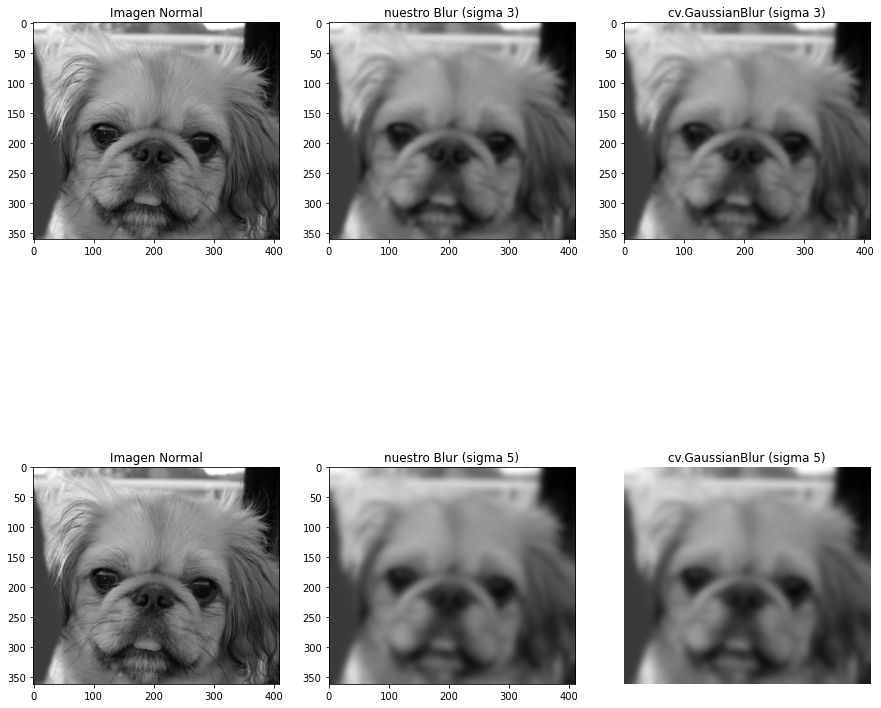

In [15]:
def ejercicio3_apartadoA(imagenNormal):

    fig = plt.figure(figsize=(15, 15))
    rows = 2
    columns = 3

    # Añadimos un subplot 
    fig.add_subplot(rows, columns, 1)
    # Mostramos las imagenes.
    plt.imshow(imagenNormal, cmap='gray')
    plt.title("Imagen Normal")
    # Generamos la máscara gaussiana usando las funciones del apartado A.
    kernel_gaussiano = mascaraGaussiana1D(3,None)
    imagenBlur = convolucionar(kernel_gaussiano ,kernel_gaussiano, imagenNormal)

    # Añadimos un subplot 
    fig.add_subplot(rows, columns, 2)
    # Mostramos las imagenes.
    plt.imshow(imagenBlur, cmap='gray')
    plt.title("nuestro Blur (sigma 3)")
    

    imagenOpenCV = cv.GaussianBlur(imagenNormal, ksize = (0,0), sigmaX=3)
    # showing image
    fig.add_subplot(rows, columns, 3)
    plt.imshow(imagenOpenCV, cmap='gray')
    plt.title("cv.GaussianBlur (sigma 3)")

    # Añadimos un subplot 
    fig.add_subplot(rows, columns, 4)
    # Mostramos las imagenes.
    plt.imshow(imagenNormal, cmap='gray')
    plt.title("Imagen Normal")
    # Generamos la máscara gaussiana usando las funciones del apartado A.
    kernel_gaussiano = mascaraGaussiana1D(5,None)
    imagenBlur = convolucionar(kernel_gaussiano ,kernel_gaussiano, imagenNormal)

    # Añadimos un subplot 
    fig.add_subplot(rows, columns, 5)
    # Mostramos las imagenes.
    plt.imshow(imagenBlur, cmap='gray')
    plt.title("nuestro Blur (sigma 5)")
    

    imagenOpenCV = cv.GaussianBlur(imagenNormal, ksize = (0,0), sigmaX=5)
    # showing image
    fig.add_subplot(rows, columns, 6)
    plt.imshow(imagenOpenCV, cmap='gray')
    plt.axis('off')
    plt.title("cv.GaussianBlur (sigma 5)")

# Parámetro configurable del ejercicio 3.a - imagen.
imagen = cv.imread('./imagenes/dog.bmp', 0)

ejercicio3_apartadoA(imagen)


## Como podemos ver, los resultados son, si no idénticos, muy parecidos, lo que quiere decir que la convolución está bien realizada.
## Veremos la diferencia por píxel y en porcentaje que hay entre las imágenes, por ejemplo, con un sigma = 3.

In [16]:
imagen = cv.imread('./imagenes/dog.bmp', 0)

kernel_gaussiano = mascaraGaussiana1D(3,None)
imagenBlur = convolucionar(kernel_gaussiano ,kernel_gaussiano, imagen)

imagenOpenCV = cv.GaussianBlur(imagen, ksize = (0,0), sigmaX=3)
distancia = np.linalg.norm(imagenBlur-imagenOpenCV)
print(distancia / (imagenBlur.shape[0] * imagenBlur.shape[1]) / 255)

0.0013451667888776451


## Como podemos ver, la distancia es muy baja (sobre 1, un 0.001 por píxel de media); ya se podía apreciar gráficamente pero me parecía interesante y curioso ver la diferencia.



## A continuación, procederemos a hacer el segundo apartado del ejercicio, que es el cálculo de la imagen derivada de X e Y respecto una imagen dada.
## Para calcular la derivada en X de una imagen, al tener implementada la convolución de una imagen con dos vectores 1D, primero convolucionaremos por filas con el vector de la derivada de la gaussiana (de un sigma que queramos, pero cuanto mayor sigma, más borrosa será la imagen derivada), y, como por columnas no queremos derivar (ya que es la derivada en X) le pasamos el kernel de la gaussiana.
## Muy parecido para la derivada en Y, convolucionaremos por filas con un kernel gaussiano de un sigma específico, y por columnas con un kernel derivada de gaussiana del mismo sigma.

## El resultado en ambos casos será la imagen derivada (en X o en Y) de la imagen dada.
## Apunte: el sigma es un parámetro de la función de este apartado, al igual que la imagen.

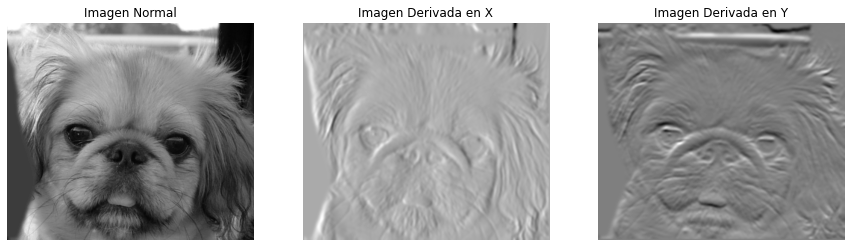

In [17]:
def ejercicio3_apartadoB(imagenNormal, sigma):

    kernel_gaussiano = mascaraGaussiana1D(2,None)
    kernel_derivada = mascaraGaussiana1D_derivada(2,None)

    fig = plt.figure(figsize=(15, 15))
    rows = 1
    columns = 3

    # Imagen normal
    fig.add_subplot(rows, columns, 1)
    plt.imshow(imagenNormal, cmap='gray')
    plt.axis('off')
    plt.title("Imagen Normal")
    
    # Derivada en X
    imagenDerivadaX = convolucionar(kernel_derivada, kernel_gaussiano, imagenNormal)
    fig.add_subplot(rows, columns, 2)
    plt.imshow(imagenDerivadaX, cmap='gray')
    plt.axis('off')
    plt.title("Imagen Derivada en X")
    
    # Derivada en Y
    imagenDerivadaY = convolucionar(kernel_gaussiano, kernel_derivada, imagenNormal)
    fig.add_subplot(rows, columns, 3)
    plt.imshow(imagenDerivadaY, cmap='gray')
    plt.axis('off')
    plt.title("Imagen Derivada en Y")

# Parámetros configurables del ejercicio. La imagen y el sigma.
imagen = cv.imread('./imagenes/dog.bmp', 0)
sigma = 3
ejercicio3_apartadoB(imagen, sigma)

    

## Como ya vimos en teoría, y podemos deducir que está aplicandose bien la derivada en cada eje, la derivada en X nos da información de los "saltos" de intensidad en el eje X, es decir, horizontales, y la derivada en Y nos da información de los saltos verticales, por ejemplo, en la lengua del perro.

# Ejercicio 4. Calcular máscaras normalizadas de la laplaciana de una Gaussiana.
# Para hacer esto, debemos de saber en primera instancia que la laplaciana es la suma de las dos segundas derivadas de la función Gaussiana, la segunda derivada en X y la segunda derivada en Y.
# $ Laplaciana = sigma^2 * (Gxx(x,y,sigma) + Gyy(x,y,sigma)) $
# Sabemos calcular cada una de esas cosas, ya que sigma es un parámetro a fijar (que determinará el tamaño de la laplaciana) y Gxx y Gyy son las segundas derivadas de la gaussiana.
# Como nosotros tendremos que trabajar con los kernel 1D para obtener la laplaciana de una imagen, podemos razonarlo de la siguiente manera:
1. # Convolucionar una imagen con el kernel 2D de la segunda derivada de la gaussiana en X es igual a convolucionar, por filas, con la segunda derivada de la gaussiana en su versión 1D, y por columnas, con la gaussiana en 1d.
2. # Convolucionar una imagen con el kernel 2D de la segunda derivada de la gaussiana en Y es igual a convolucionar, por filas, con la gaussiana en su versión 1D, y por columnas, con la segundna derivada de la gaussiana en 1D.

# Por tanto, llegamos a la conclusión de que con dos únicas máscaras 1D podemos hallar la laplaciana de una imagen (sólo nos basta con la gaussiana en 1D y con su segunda derivada en 1D, que ya sabemos, y hemos comentado, que en X y en Y son iguales). Con esas dos máscaras haremos lo mencionado anteriormente.

# Por tanto, se procederá a enseñar los kernels de la laplaciana por consola, dado un sigma determinado (que calculará automáticamente la longitud del kernel de salida) y posteriormente haremos lo comentado anteriormente sobre una imagen: hallaremos la segunda derivada de la imagen en X (punto 1 de arriba) y la segunda derivada de la imagen en Y (punto 2 de arriba), las sumaremos y las multiplicaremos por $sigma^2$.
# Haremos una comparativa de la laplaciana de una imagen con sigma 1 y 2, con las imágenes obtenidas de la función cv.Laplacian con tamaños de máscara 5 y 17 (equivalentes a sigma 1 y 3), y usando bordes reflejados (definido el borderType como $cv.BORDER REFLECT101$)


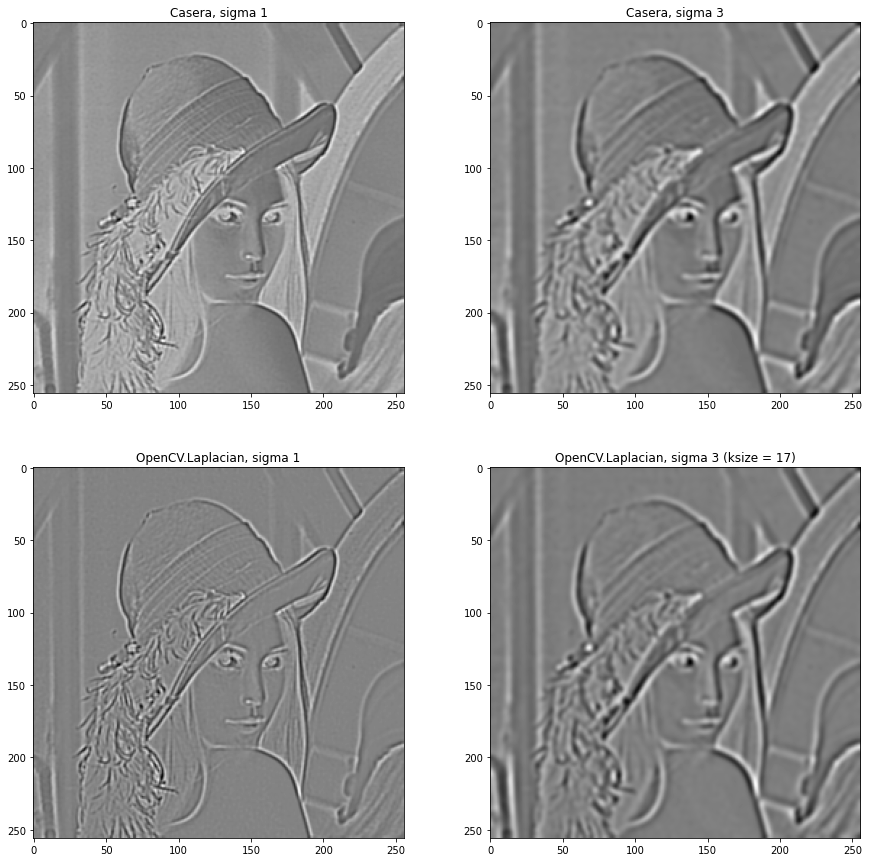

In [18]:
# Ejercicio 4. Para calcular la máscara normalizada de la Laplaciana de una Gaussiana, tenemos que:
# 1. convolucionar por filas con la derivada segunda de la Gaussiana y, luego, por columnas, la convolución con la Gaussiana.
# 2. convolucionar por filas con la Gaussiana y, luego, por columnas, la convolución con la segunda derivada de la Gaussiana.
# 3. Sumar lo obtenido anteriormente.
# 4. Multiplicar el resultado anterior por sigma^2 (para normalizarlo)

def calcularLaplaciana(imagen2d, sigma):

    derivadaSegunda = mascaraGaussiana1D_derivada_segunda(sigma, None)

    primeraConvolucion = convolucionar(derivadaSegunda, mascaraGaussiana1D(sigma, None), imagen2d)
    segundaConvolucion = convolucionar(mascaraGaussiana1D(sigma,None), derivadaSegunda, imagen2d)

    imagenFinal = (primeraConvolucion + segundaConvolucion) * sigma**2

    return imagenFinal


def ejercicio4(imagen2d):

    fig = plt.figure(figsize=(15, 15))
    rows = 2
    columns = 2

    fig.add_subplot(rows, columns, 1)
    plt.imshow(calcularLaplaciana(imagen2d, 1), cmap='gray')
    plt.title("Casera, sigma 1")

    fig.add_subplot(rows, columns, 2)
    plt.imshow(calcularLaplaciana(imagen2d, 2), cmap='gray')
    plt.title("Casera, sigma 3")

    fig.add_subplot(rows, columns, 3)
    plt.imshow(cv.Laplacian(imagen2d, ddepth=cv.CV_64F, ksize = 5, borderType=cv.BORDER_REFLECT101) , cmap='gray')
    plt.title("OpenCV.Laplacian, sigma 1")

    fig.add_subplot(rows, columns, 4)
    plt.imshow(cv.Laplacian(imagen2d, ddepth=cv.CV_64F, ksize = 17, borderType=cv.BORDER_REFLECT101), cmap='gray')
    plt.title("OpenCV.Laplacian, sigma 3 (ksize = 17)")

imagen2d = cv.imread('./imagenes/lena.jpg', 0)
ejercicio4(imagen2d)



# Podemos apreciar que las laplacianas son prácticamente iguales en cuanto a formato, cosa que nos indica que lo hemos hecho de manera correcta (con su pequeña desviación).
# Los pros de nuestra función es que podemos fijar un sigma con el cual vamos a realizar la convolución de las máscaras, y, por lo que he leído, la función de la laplaciana de OpenCV sólo te permite seleccionar el tamaño del kernel y ajusta el sigma según ese tamaño.
# El contra más importante es que en la funcion Laplacian de OpenCV podemos fijar el tipo de bordes que queremos hacer a la hora de extrapolar los píxeles, cosa que aquí fijamos en la convolución, pero no es un parámetro externo.
# Otra cosa que me he fijado leyendo la documentación de OpenCV es que no normaliza la Laplaciana, es decir, no multiplica por $sigma^2$ (o al menos en la documentación de https://docs.opencv.org/4.5.3/d4/d86/group__imgproc__filter.html#gad78703e4c8fe703d479c1860d76429e6 indica esto), sino que hace la suma de ambas convoluciones 2D, pero no normaliza.

# De hecho, voy a ver cuánto hay de diferencia de media por píxel entre la laplaciana creada a mano y la función de OpenCV.


In [19]:
miLaplaciana = calcularLaplaciana(imagen2d, 1)
openCVLaplaciana = normalizar(cv.Laplacian(imagen2d, ddepth=cv.CV_64F, ksize = 5, borderType=cv.BORDER_REFLECT101))

distancia = np.linalg.norm(miLaplaciana-openCVLaplaciana)
print(distancia / (miLaplaciana.shape[0] * miLaplaciana.shape[1]) * 100)

0.20032153450086232


# Como vemos, la diferencia de media por píxel es muy pequeña, de un 0,2% por píxel.

## Eso nos quiere decir que nuestros cálculos no están tan mal.

Text(0.5, 1.0, 'Pirámide implementando PyrDown')

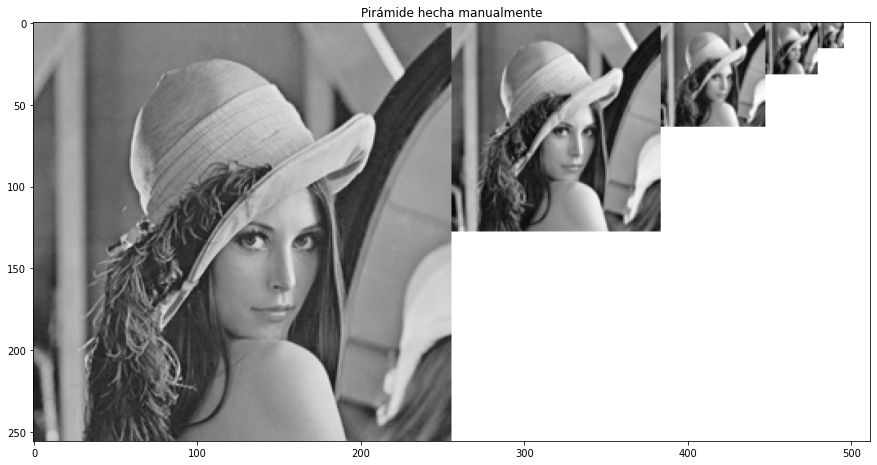

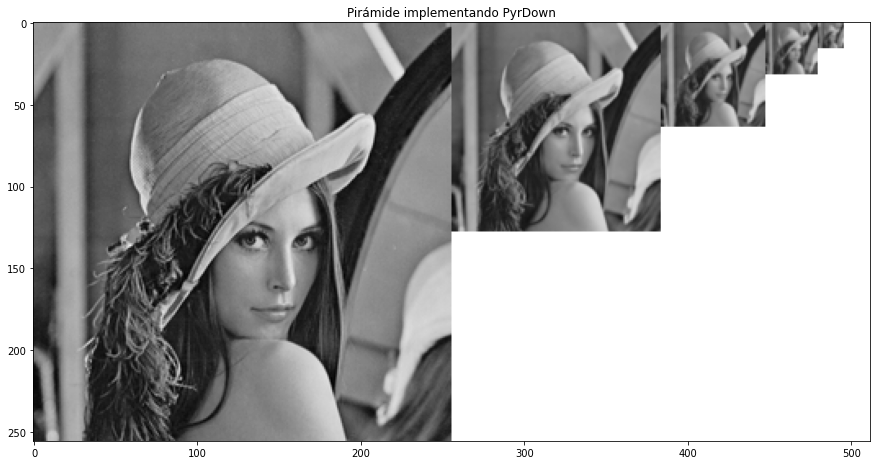

In [20]:
def subsamplear(imagen):
    return imagen[::2, ::2]

def filtroBlur(imagen, sigma):
    kernel_gaussiano = mascaraGaussiana1D(sigma,None)
    return (convolucionar(kernel_gaussiano ,kernel_gaussiano, imagen))

def piramideGaussiana(imagen, sigma):
    # Creamos la piramide donde caben todas las imágenes (las vamos a añadir en horizontal)
    piramide = np.zeros([imagen.shape[0],imagen.shape[1] * 2],dtype=np.float64)
    piramide.fill(1)
    # Insertamos la primera imagen
    piramide[0:imagen.shape[0] , 0:imagen.shape[1]] = imagen[0:imagen.shape[0] , 0:imagen.shape[1]]

    # El proceso ahora es repetitivo. Blureamos la imagen (empezamos con sigma 1, y duplicamos el sigma en cada iteración)
    # Luego la subsampleamos (reducimos a la mitad su tamaño) y la añadimos a la matriz.
    imagen2 = filtroBlur(imagen, sigma)
    imagen2 = subsamplear(imagen2)

    ## Añadimos la imagen 2 a la pirámide que hemos creado.
    piramide[0: imagen2.shape[0] , imagen.shape[1]: imagen.shape[1] + imagen2.shape[1] ] = imagen2[0:imagen2.shape[0] , 0:imagen2.shape[1]]

    # Lo mismo con la imagen 3 y 4: duplicamos el sigma, le aplicamos el filtro y subsampleamos.
    #sigma = 2 * sigma
    imagen3 = filtroBlur(imagen2,sigma)
    imagen3 = subsamplear(imagen3)

    # Añadimos a la pirámide la 3º imagen.
    piramide[0: imagen3.shape[0] , imagen.shape[1] + imagen2.shape[1]  : imagen.shape[1] + imagen2.shape[1] + imagen3.shape[1] ] = imagen3[0:imagen3.shape[0] , 0:imagen3.shape[1] ]

    # Hacemos lo mismo con la cuarta imagen.
    #sigma = 2 * sigma
    imagen4 = filtroBlur(imagen3,sigma)
    imagen4 = subsamplear(imagen4)
    # Añadimos a la pirámide la 4º imagen.
    piramide[0: imagen4.shape[0] , imagen.shape[1] + imagen2.shape[1] + imagen3.shape[1]  : imagen.shape[1] + imagen2.shape[1] + imagen3.shape[1] + imagen4.shape[1] ] = imagen4[0:imagen4.shape[0] , 0:imagen4.shape[1] ]
    
    # Incluimos la quinta imagen de la pirámide (que sería el cuarto piso, el máximo que nos piden, ya que el piso 0 es la imagen original)
    #sigma = 2 * sigma
    imagen5 = filtroBlur(imagen4,sigma)
    imagen5 = subsamplear(imagen5)
    # Añadimos a la pirámide la 4º imagen.
    piramide[0: imagen5.shape[0] , imagen.shape[1] + imagen2.shape[1] + imagen3.shape[1] + imagen4.shape[1]  : imagen.shape[1] + imagen2.shape[1] + imagen3.shape[1] + imagen4.shape[1] + imagen5.shape[1] ] = imagen5[0:imagen5.shape[0] , 0:imagen5.shape[1] ]

    return piramide, imagen,imagen2,imagen3,imagen4,imagen5

def piramideGaussianaOpenCV(imagen):
    # Creamos la piramide donde caben todas las imágenes (las vamos a añadir en horizontal)
    piramide = np.zeros([imagen.shape[0],imagen.shape[1] * 2],dtype=np.float64)
    piramide.fill(1)
    # Insertamos la primera imagen
    piramide[0:imagen.shape[0] , 0:imagen.shape[1]] = imagen[0:imagen.shape[0] , 0:imagen.shape[1]]

    # El proceso ahora es repetitivo. Blureamos la imagen (empezamos con sigma 1, y duplicamos el sigma en cada iteración)
    # Luego la subsampleamos (reducimos a la mitad su tamaño) y la añadimos a la matriz.
    imagen2 = cv.pyrDown(imagen, borderType=cv.BORDER_REFLECT101)

    ## Añadimos la imagen 2 a la pirámide que hemos creado.
    piramide[0: imagen2.shape[0] , imagen.shape[1]: imagen.shape[1] + imagen2.shape[1] ] = imagen2[0:imagen2.shape[0] , 0:imagen2.shape[1]]

    # Lo mismo con la imagen 3 y 4: duplicamos el sigma, le aplicamos el filtro y subsampleamos.
    #sigma = 2 * sigma
    imagen3 = cv.pyrDown(imagen2, borderType=cv.BORDER_REFLECT101)
    # Añadimos a la pirámide la 3º imagen.
    piramide[0: imagen3.shape[0] , imagen.shape[1] + imagen2.shape[1]  : imagen.shape[1] + imagen2.shape[1] + imagen3.shape[1] ] = imagen3[0:imagen3.shape[0] , 0:imagen3.shape[1] ]

    # Hacemos lo mismo con la cuarta imagen.
    #sigma = 2 * sigma
    imagen4 = cv.pyrDown(imagen3, borderType=cv.BORDER_REFLECT101)
    # Añadimos a la pirámide la 4º imagen.
    piramide[0: imagen4.shape[0] , imagen.shape[1] + imagen2.shape[1] + imagen3.shape[1]  : imagen.shape[1] + imagen2.shape[1] + imagen3.shape[1] + imagen4.shape[1] ] = imagen4[0:imagen4.shape[0] , 0:imagen4.shape[1] ]
    
    # Incluimos la quinta imagen de la pirámide (que sería el cuarto piso, el máximo que nos piden, ya que el piso 0 es la imagen original)
    #sigma = 2 * sigma
    imagen5 = cv.pyrDown(imagen4, borderType=cv.BORDER_REFLECT101)
    # Añadimos a la pirámide la 4º imagen.
    piramide[0: imagen5.shape[0] , imagen.shape[1] + imagen2.shape[1] + imagen3.shape[1] + imagen4.shape[1]  : imagen.shape[1] + imagen2.shape[1] + imagen3.shape[1] + imagen4.shape[1] + imagen5.shape[1] ] = imagen5[0:imagen5.shape[0] , 0:imagen5.shape[1] ]

    return piramide,imagen,imagen2,imagen3,imagen4,imagen5


imagen2d = cv.imread('./imagenes/lena.jpg', 0)
imagen2d = imagen2d/255
sigma = 1
piramide = piramideGaussiana(imagen2d, sigma)
pintaI(piramide[0])
plt.title("Pirámide hecha manualmente")
piramideOpenCV = piramideGaussianaOpenCV(imagen2d)
pintaI(piramideOpenCV[0])
plt.title("Pirámide implementando PyrDown")

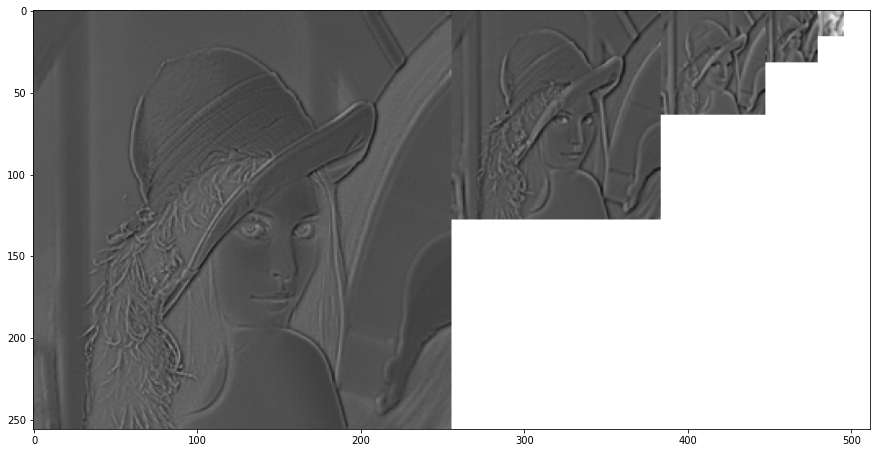

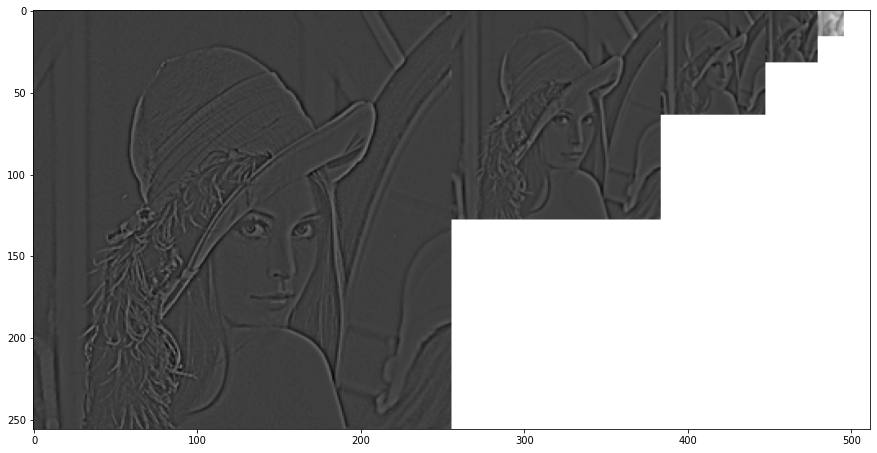

In [21]:
def piramideLaplaciana(imagen, sigma):
    
    (piramide, imagen, imagen2, imagen3, imagen4, imagen5) = piramideGaussiana(imagen,sigma)
    ## Laplaciana
    # Volvemos hacia arriba.
    imagen5_expandida = cv.resize(imagen5, (imagen4.shape[1], imagen4.shape[0]), interpolation=cv.INTER_LINEAR)
    imagenextra = imagen4 - imagen5_expandida
    piramide[0: imagen4.shape[0] , imagen.shape[1] + imagen2.shape[1] + imagen3.shape[1]  : imagen.shape[1] + imagen2.shape[1] + imagen3.shape[1] + imagen4.shape[1] ] = imagenextra[0:imagenextra.shape[0] , 0:imagenextra.shape[1] ]

    imagen4_expandida = cv.resize(imagen4, (imagen3.shape[1], imagen3.shape[0]), interpolation=cv.INTER_LINEAR)
    imagenextra = imagen3 - imagen4_expandida
    piramide[0: imagen3.shape[0] , imagen.shape[1] + imagen2.shape[1]  : imagen.shape[1] + imagen2.shape[1] + imagen3.shape[1] ] = imagenextra[0:imagenextra.shape[0] , 0:imagenextra.shape[1] ]
    
    imagen3_expandida = cv.resize(imagen3, (imagen2.shape[1], imagen2.shape[0]), interpolation=cv.INTER_LINEAR)
    imagenextra = imagen2 - imagen3_expandida
    piramide[0: imagen2.shape[0] , imagen.shape[1]: imagen.shape[1] + imagen2.shape[1] ] = imagenextra[0:imagenextra.shape[0] , 0:imagenextra.shape[1]]

    imagen2_expandida = cv.resize(imagen2, (imagen.shape[1], imagen.shape[0]), interpolation=cv.INTER_LINEAR)
    imagenextra = imagen - imagen2_expandida
    piramide[0:imagen.shape[0] , 0:imagen.shape[1]] = imagenextra[0:imagenextra.shape[0] , 0:imagenextra.shape[1]]

    return piramide,imagen,imagen2,imagen3,imagen4,imagen5

def piramideLaplacianaOpenCV(imagen):

    (piramide, imagen, imagen2, imagen3, imagen4, imagen5) = piramideGaussianaOpenCV(imagen)
    ## Laplaciana
    # Volvemos hacia arriba.
    size = (imagen4.shape[1], imagen4.shape[0])
    imagen5_expandida = cv.pyrUp(imagen5, borderType=cv.BORDER_REFLECT101, dstsize=size)
    imagenextra = imagen4 - imagen5_expandida
    piramide[0: imagen4.shape[0] , imagen.shape[1] + imagen2.shape[1] + imagen3.shape[1]  : imagen.shape[1] + imagen2.shape[1] + imagen3.shape[1] + imagen4.shape[1] ] = imagenextra[0:imagenextra.shape[0] , 0:imagenextra.shape[1] ]

    size = (imagen3.shape[1], imagen3.shape[0])
    imagen4_expandida = cv.pyrUp(imagen4, borderType=cv.BORDER_REFLECT101, dstsize=size)
    imagenextra = imagen3 - imagen4_expandida
    piramide[0: imagen3.shape[0] , imagen.shape[1] + imagen2.shape[1]  : imagen.shape[1] + imagen2.shape[1] + imagen3.shape[1] ] = imagenextra[0:imagenextra.shape[0] , 0:imagenextra.shape[1] ]
    
    size = (imagen2.shape[1], imagen2.shape[0])
    imagen3_expandida = cv.pyrUp(imagen3, borderType=cv.BORDER_REFLECT101, dstsize=size)
    imagenextra = imagen2 - imagen3_expandida
    piramide[0: imagen2.shape[0] , imagen.shape[1]: imagen.shape[1] + imagen2.shape[1] ] = imagenextra[0:imagenextra.shape[0] , 0:imagenextra.shape[1]]

    size = (imagen.shape[1], imagen.shape[0])
    imagen2_expandida = cv.pyrUp(imagen2, borderType=cv.BORDER_REFLECT101, dstsize = size)
    imagenextra = imagen - imagen2_expandida
    piramide[0:imagen.shape[0] , 0:imagen.shape[1]] = imagenextra[0:imagenextra.shape[0] , 0:imagenextra.shape[1]]

    return piramide,imagen,imagen2,imagen3,imagen4,imagen5

imagen2d = cv.imread('./imagenes/lena.jpg', 0)
imagen2d = imagen2d/255
sigma = 1
laplaciana = piramideLaplaciana(imagen2d, sigma)[0]
pintaI(laplaciana)
laplacianaOpenCV = piramideLaplacianaOpenCV(imagen2d)[0]
pintaI(laplacianaOpenCV)


[[255 255 255 ...  29  32  35]
 [255 255 255 ...  28  32  34]
 [255 255 255 ...  29  31  35]
 ...
 [ 52  65  72 ...  40  34  43]
 [ 51  67  73 ...  51  40  33]
 [ 46  66  74 ...  54  45  40]]


Text(0.5, 1.0, 'Imagen recuperada usando la pirámide laplaciana')

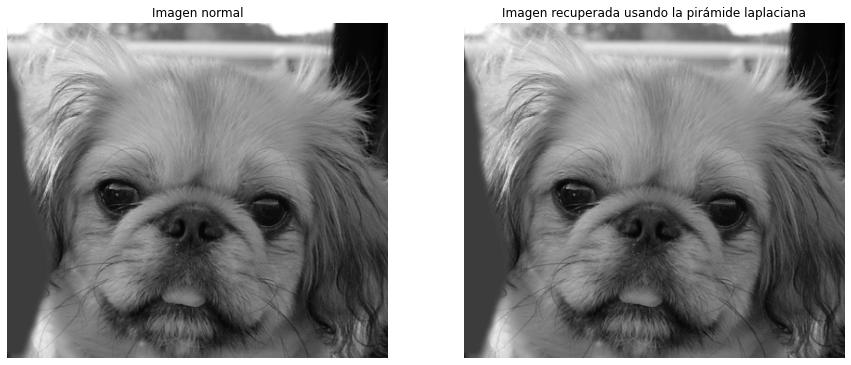

In [22]:
def recuperarImagen(imagen, sigma):
    (piramide, imagen, imagen2, imagen3, imagen4, imagen5) = piramideLaplaciana(imagen,sigma)

    # Upsampleamos la imagen 5 (la cima de la pirámide)
    imagen5 = cv.resize(imagen5, (imagen4.shape[1] , imagen4.shape[0]), interpolation=cv.INTER_LINEAR)
    print(imagen)
    # Le sumamos la laplaciana de la capa 4
    imagen4_recuperada = imagen4 + imagen5
    # Repetimos lo mismo con cada una de las capas, la imagen recuperada se le hace upsample y se suma con la laplaciana de ese nivel de escalado
    imagen4_recuperada = cv.resize(imagen4_recuperada, (imagen3.shape[1] , imagen3.shape[0]), interpolation=cv.INTER_LINEAR)
    # Sumamos laplaciana de capa 3.
    imagen3_recuperada = imagen3 + imagen4_recuperada
    # Se le hace upsampling
    imagen3_recuperada = cv.resize(imagen3_recuperada, (imagen2.shape[1] , imagen2.shape[0]), interpolation=cv.INTER_LINEAR)
    # Se suma con la laplaciana de esa capa
    imagen2_recuperada = imagen2 + imagen3_recuperada
    # Upsampling de nuevo
    imagen2_recuperada = cv.resize(imagen2_recuperada, (imagen.shape[1] , imagen.shape[0]), interpolation=cv.INTER_LINEAR)
    # Llegamos a la última capa. Sumamos esta imagen recuperada y upsampleada con la laplaciana base.
    imagen_recuperada = imagen + imagen2_recuperada

    return imagen_recuperada


imagen2d = cv.imread('./imagenes/dog.bmp', 0)
sigma = 1
imagenRecuperada = recuperarImagen(imagen2d, sigma)

fig = plt.figure(figsize=(15, 15))
rows = 1
columns = 2

fig.add_subplot(rows, columns, 1)
plt.imshow(imagen2d, cmap='gray')
plt.axis('off')
plt.title("Imagen normal")

fig.add_subplot(rows, columns, 2)
plt.imshow(imagenRecuperada, cmap='gray')
plt.axis('off')
plt.title("Imagen recuperada usando la pirámide laplaciana")


In [23]:
distancia = np.linalg.norm(imagen2d-imagenRecuperada)
print(distancia / (imagen2d.shape[0] * imagen2d.shape[1]) * 100)

0.49751895454559536


## Vemos que la distancia de media, por píxel, es alrededor de un 0,5%. Visualmente no se aprecia, y lo considero relativamente pequeña, tanto en cálculos como en visualización, lo que nos quiere decir que la pirámide laplaciana cumple su función a la hora de restaurar la imagen.

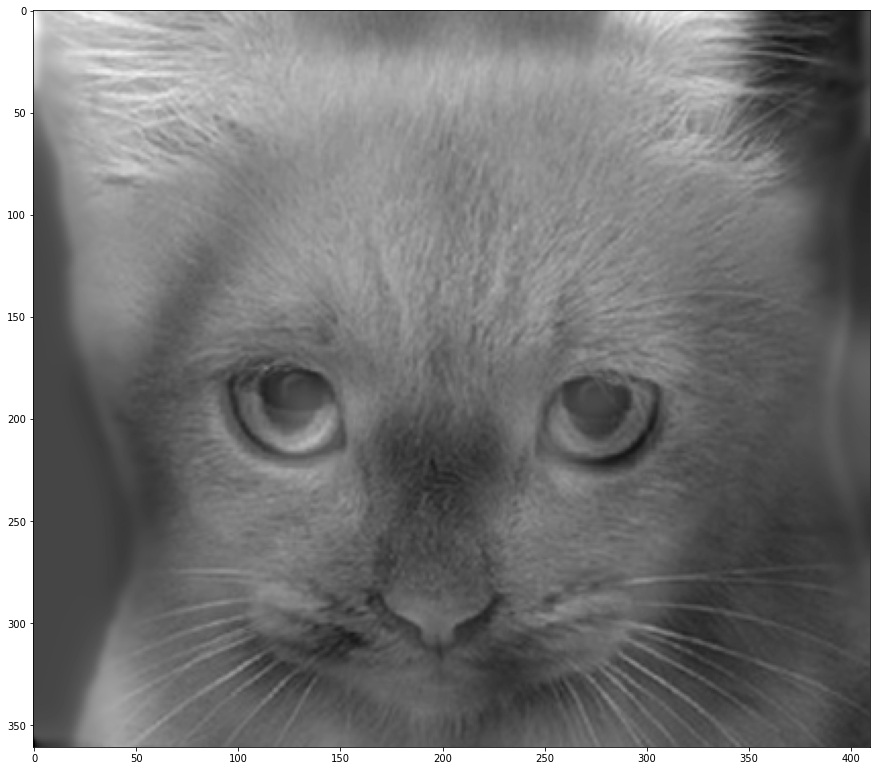

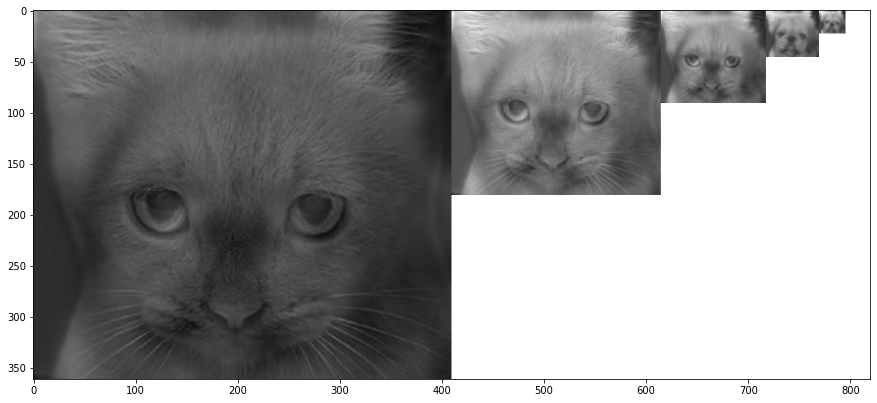

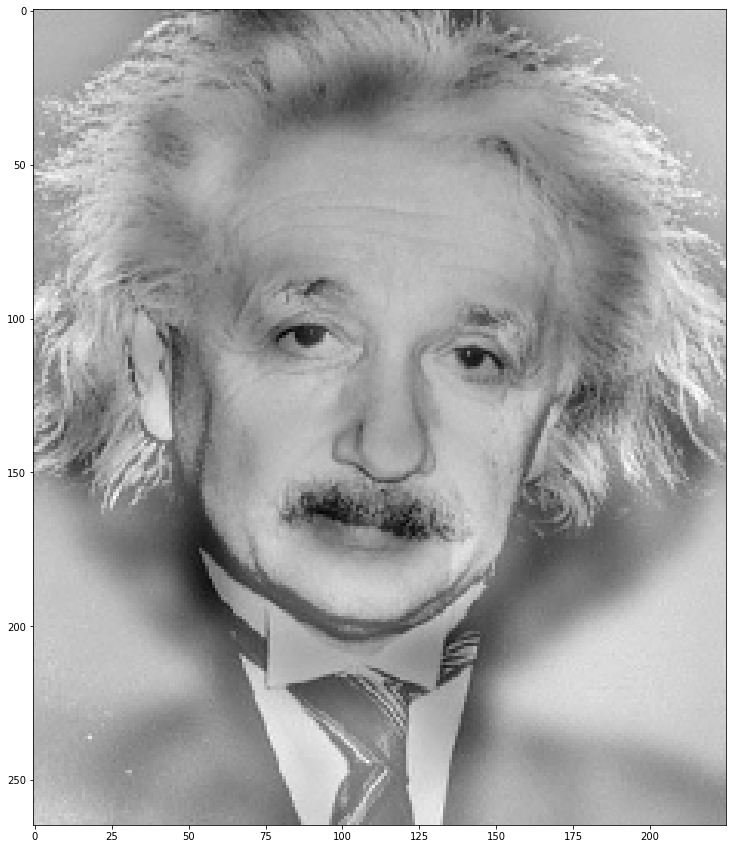

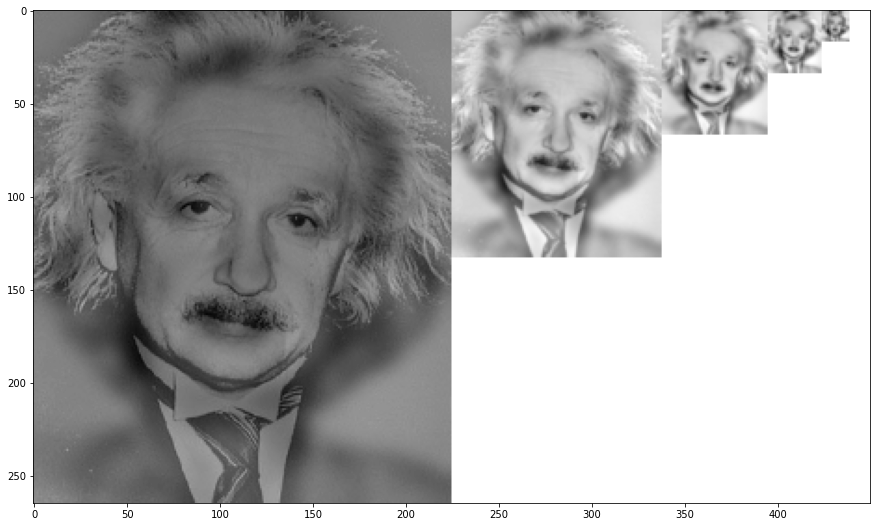

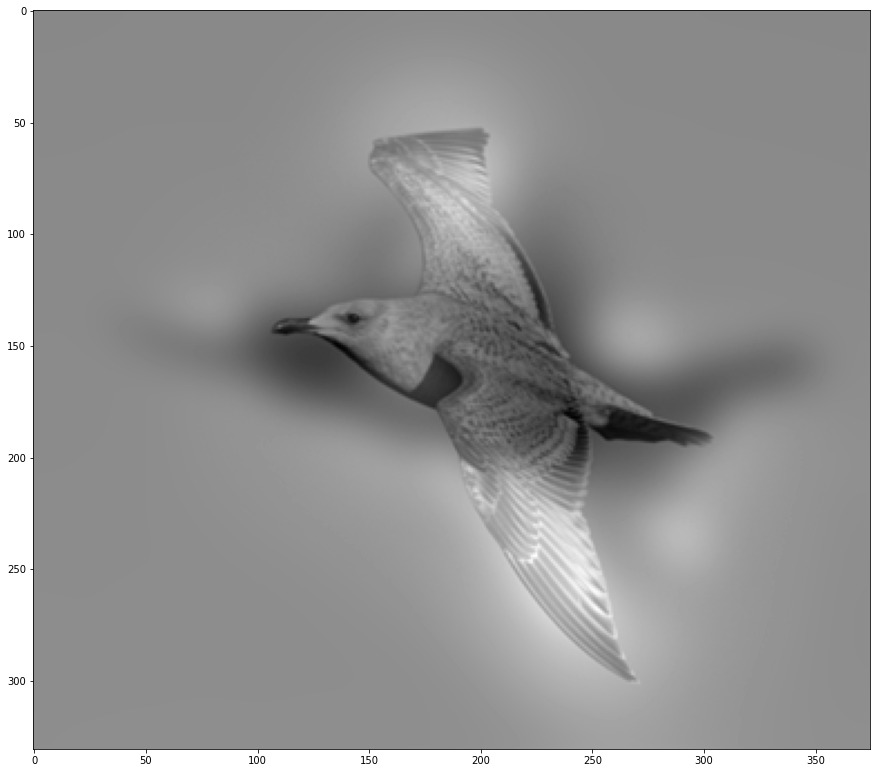

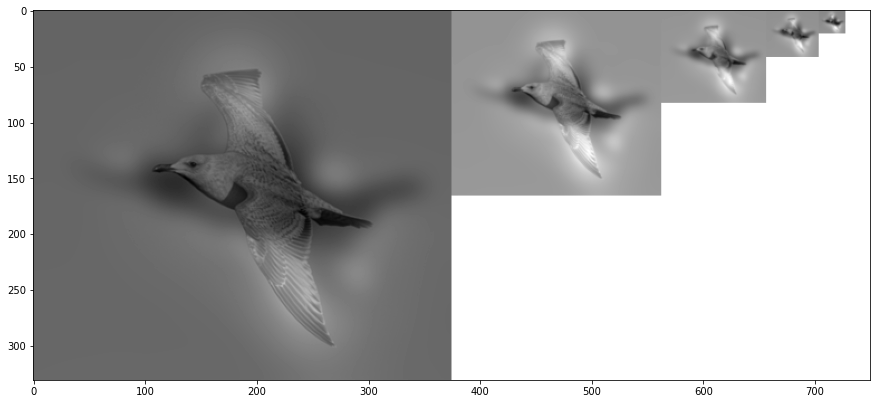

In [24]:
def imagenHibridaGris(imagen1, imagen2, sigma1, sigma2):
    # Extraemos las bajas frecuencias de la imagen 1 con un blur de sigma1.
    imagen1_filtrada_bajo = filtroBlur(imagen1, sigma1)
    imagen2_filtrada_alto = (filtroBlur(imagen2,sigma2))
    imagen2_filtrada_alto = imagen2 - imagen2_filtrada_alto
    imagenHibrida = (imagen1_filtrada_bajo + imagen2_filtrada_alto)/2

    return imagen1_filtrada_bajo, imagen2_filtrada_alto, imagenHibrida

imagen1 = cv.imread('./imagenes/dog.bmp', 0)
imagen1 = imagen1 / 255
imagen2 = cv.imread('./imagenes/cat.bmp', 0)
imagen2 = imagen2 / 255
imagen_hibrida = imagenHibridaGris(imagen1, imagen2, 8, 8)[2]
pintaI(imagen_hibrida)
piramide = piramideGaussiana(imagen_hibrida, 1)
pintaI(piramide[0])

imagen1 = cv.imread('./imagenes/marilyn.bmp', 0)
imagen1 = imagen1 / 255
imagen2 = cv.imread('./imagenes/einstein.bmp', 0)
imagen2 = imagen2 / 255
imagen_hibrida = imagenHibridaGris(imagen1, imagen2, 5, 10)[2]
pintaI(imagen_hibrida)
piramide = piramideGaussiana(imagen_hibrida, 1)
pintaI(piramide[0])

imagen1 = cv.imread('./imagenes/plane.bmp', 0)
imagen1 = imagen1 / 255
imagen2 = cv.imread('./imagenes/bird.bmp', 0)
imagen2 = imagen2 / 255
imagen_hibrida = imagenHibridaGris(imagen1, imagen2, 10, 24)[2]
pintaI(imagen_hibrida)
piramide = piramideGaussiana(imagen_hibrida, 1)
pintaI(piramide[0])



[[ 0.57986853  0.54339502  0.50649526 ...  0.03377494  0.05710101
   0.068131  ]
 [ 0.59898182  0.56250808  0.51580373 ...  0.03392514  0.0592127
   0.07024293]
 [ 0.61320512  0.57280917  0.52806362 ...  0.03633985  0.05966891
   0.07266072]
 ...
 [-0.13611629 -0.04200075 -0.00082068 ... -0.00357781 -0.00588819
   0.00182606]
 [-0.15473222 -0.07042153 -0.03120485 ... -0.01165275 -0.00611623
   0.00355988]
 [-0.15635756 -0.08577268 -0.04851769 ... -0.00389357  0.00360512
   0.0132816 ]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[ 0.56808135  0.57986853  0.58402538]
  [ 0.54880949  0.54339502  0.53587336]
  [ 0.52628759  0.50649526  0.48158852]
  ...
  [ 0.06334381  0.03377494  0.03880823]
  [ 0.07804634  0.05710101  0.07317734]
  [ 0.08163545  0.068131    0.09376713]]

 [[ 0.58509824  0.59898182  0.61289931]
  [ 0.56190496  0.56250808  0.56082577]
  [ 0.53742265  0.51580373  0.50458045]
  ...
  [ 0.0634207   0.03392514  0.03907002]
  [ 0.07616239  0.0592127   0.07147979]
  [ 0.08367307  0.07024293  0.09010928]]

 [[ 0.59889256  0.61320512  0.63481649]
  [ 0.57569982  0.57280917  0.58078243]
  [ 0.54337566  0.52806362  0.52649877]
  ...
  [ 0.06364535  0.03633985  0.04181377]
  [ 0.0783479   0.05966891  0.07226718]
  [ 0.08781938  0.07266072  0.0889374 ]]

 ...

 [[-0.0678937  -0.13611629 -0.19533496]
  [ 0.0262401  -0.04200075 -0.10120021]
  [ 0.06747202 -0.00082068 -0.05997353]
  ...
  [ 0.05237494 -0.00357781 -0.01166965]
  [ 0.05400444 -0.00588819 -0.01397586]
  [ 0.05583916  0.00182606 -0.01018625]]

 [

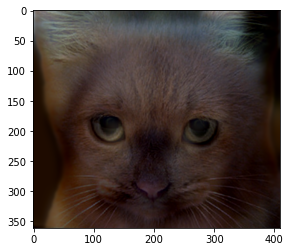

In [28]:
def floatToUnsigned(imagen):
    imagen = normalizar(imagen)
    imagen = imagen * 255
    return imagen

def imagenHibridaColor(imagen1, imagen2, sigma1, sigma2):
    # Sacamos los canales de manera separada con la funcion cv.split
    i1b,i1g,i1r = cv.split(imagen1)
    i2b,i2g,i2r = cv.split(imagen2)

    # CANAL AZUL
    i1b_bajo = filtroBlur(i1b, sigma1)
    i2b_alto = (filtroBlur(i2b,sigma2))
    i2b_alto = i2b - i2b_alto
    ib = (i1b_bajo + i2b_alto)/2

    # CANAL VERDE
    i1g_bajo = filtroBlur(i1g, sigma1)
    i2g_alto = (filtroBlur(i2g,sigma2))
    i2g_alto = i2g - i2g_alto
    ig = (i1g_bajo + i2g_alto)/2

    print(ig)

    # CANAL ROJO
    i1r_bajo = filtroBlur(i1r, sigma1)
    i2r_alto = (filtroBlur(i2r,sigma2))
    i2r_alto = i2r - i2r_alto
    ir = (i1r_bajo + i2r_alto)/2

    iColor = cv.merge((ir, ig, ib))
    iColor = normalizar(iColor)
    print(iColor)

    return iColor

imagen1 = cv.imread('./imagenes/dog.bmp', 1).astype('uint8')
imagen1 = imagen1 / 255
imagen2 = cv.imread('./imagenes/cat.bmp',1).astype('uint8')
imagen2 = imagen2 / 255

imagen = imagenHibridaColor(imagen1, imagen2, 8, 8)
print(imagen)
plt.imshow(imagen)

